# Fine-Tuning Difussion model on MRI data

## Setup and Imports

In [1]:
%pip install -qq diffusers datasets accelerate wandb open-clip-torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Code to log in to the Hugging Face Hub, needed for sharing models
# Make sure you use a token with WRITE access
from huggingface_hub import notebook_login

notebook_login()

In [3]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
import os
from torch.utils.data import Dataset, DataLoader


In [4]:
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

print(f"Using device: {device}")

Using device: cuda


## Fine-Tuning

In [5]:
# Define dataset directory
dataset_dir = "/home/benet/data/VH2D/npy/flair"  # Change this to your folder path
image_size = 256
batch_size = 1

# Define transformations
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize all images
    # transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize([0.5], [0.5])  # Normalize grayscale images
])


In [6]:
# Custom dataset class for .npy
class CustomDataset(Dataset):
    def __init__(self, dataset_dir, transform=None):
        self.dataset_dir = dataset_dir
        self.transform = transform
        self.npy_files = [f for f in os.listdir(dataset_dir) if f.endswith(".npy")]

    def __len__(self):
        return len(self.npy_files)

    def __getitem__(self, idx):
        npy_path = os.path.join(self.dataset_dir, self.npy_files[idx])
        image = np.load(npy_path)  # Load numpy array
        image = Image.fromarray(image.astype(np.uint8))  # Convert to PIL Image (grayscale)

        if self.transform:
            image = self.transform(image)

        return {"images": image}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].


Previewing batch:


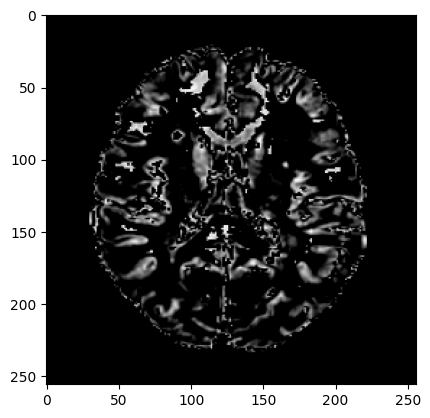

In [7]:
# Create dataset and dataloader
dataset = CustomDataset(dataset_dir, transform=preprocess)
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Preview batch
print("Previewing batch:")
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch["images"], nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().squeeze(), cmap="gray")  # Grayscale display
plt.show()

**Consideration 1:** our batch size here (4) is pretty small, since we're training at large image size (256px) using a fairly large model and we'll run out of GPU RAM if we push the batch size too high. You can reduce the image size to speed things up and allow for larger batches, but these models were designed and originally trained for 256px generation.

## Loading a Pretrained Pipeline

In [8]:
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device);

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/benet/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /home/benet/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Now for the training loop. We'll update the weights of the pre-trained model by setting the optimization target to `image_pipe.unet.parameters()`. The rest is nearly identical to the example training loop from Unit 1. This takes about 10 minutes to run on Colab, so now is a good time to grab a coffee of tea while you wait:

  0%|          | 0/285 [00:00<?, ?it/s]

/home/benet/anaconda3/envs/benetvicorob/lib/python3.12/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 1 average loss: 0.013967813279011528


  0%|          | 0/285 [00:00<?, ?it/s]

Epoch 2 average loss: 0.014002604130751264


  0%|          | 0/285 [00:00<?, ?it/s]

Epoch 3 average loss: 0.012506958528709283


  0%|          | 0/285 [00:00<?, ?it/s]

Epoch 4 average loss: 0.012809865524251476


  0%|          | 0/285 [00:00<?, ?it/s]

Epoch 5 average loss: 0.013298730671681767


  0%|          | 0/285 [00:00<?, ?it/s]

Epoch 6 average loss: 0.013092191036929235


  0%|          | 0/285 [00:00<?, ?it/s]

Epoch 7 average loss: 0.01468820728800334


  0%|          | 0/285 [00:00<?, ?it/s]

Epoch 8 average loss: 0.015173463172042127


  0%|          | 0/285 [00:00<?, ?it/s]

Epoch 9 average loss: 0.012914344057418547


  0%|          | 0/285 [00:00<?, ?it/s]

Epoch 10 average loss: 0.012567338707065159


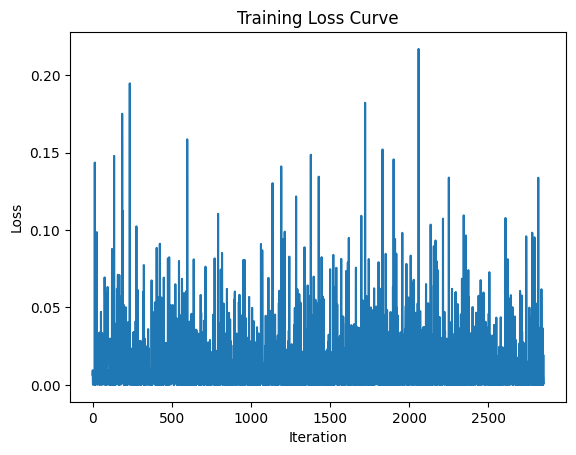

In [9]:
# Training Hyperparameters
num_epochs = 10
lr = 1e-5
grad_accumulation_steps = 8

# Optimizer
optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=lr)

losses = []

# Training Loop
for epoch in range(num_epochs):
    epoch_losses = []  # Store epoch losses for averaging
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        clean_images = batch["images"].to(device)

        # Ensure grayscale images have the right shape (Convert 1-channel to 3-channel if needed)
        if clean_images.shape[1] == 1:
            clean_images = clean_images.repeat(1, 3, 1, 1)  # Convert grayscale to RGB

        # Sample noise and timesteps
        noise = torch.randn_like(clean_images).to(device)
        bs = clean_images.shape[0]

        timesteps = torch.randint(
            0,
            image_pipe.scheduler.num_train_timesteps,
            (bs,),
            device=device,
        ).long()

        # Add noise to clean images
        noisy_images = image_pipe.scheduler.add_noise(clean_images, noise, timesteps)

        # Get noise prediction from model
        noise_pred = image_pipe.unet(noisy_images, timesteps, return_dict=False)[0]

        # Compute loss (MSE between predicted noise and actual noise)
        loss = F.mse_loss(noise_pred, noise)
        losses.append(loss.item())
        epoch_losses.append(loss.item())

        # Backpropagation
        loss.backward()

        # Gradient accumulation
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    # Print epoch loss
    avg_loss = sum(epoch_losses) / len(epoch_losses)
    print(f"Epoch {epoch+1} average loss: {avg_loss}")

# Plot loss curve
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()


**Consideration 2:** Our loss signal is extremely noisy, since we're only working with four examples at random noise levels for each step. This is not ideal for training. One fix is to use an extremely low learning rate to limit the size of the update each step. It would be even better if we could find some way to get the same benefit we would get from using a larger batch size _without_ the memory requirements skyrocketing...

Enter [gradient accumulation](https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/02/19/gradient-accumulation.html#:~:text=Simply%20speaking%2C%20gradient%20accumulation%20means,might%20find%20this%20tutorial%20useful.). If we call `loss.backward()` multiple times before running `optimizer.step()` and `optimizer.zero_grad()`, then PyTorch accumulates (sums) the gradients, effectively merging the signal from several batches to give a single (better) estimate which is then used to update the parameters. This results in fewer total updates being made, just like we'd see if we used a larger batch size. This is something many frameworks will handle for you (for example, [🤗 Accelerate makes this easy](https://huggingface.co/docs/accelerate/usage_guides/gradient_accumulation)) but it is nice to see it implemented from scratch since this is a useful technique for dealing with training under GPU memory constraints! As you can see from the code above (after the `# Gradient accumulation` comment) there really isn't much code needed.

In [10]:
# Exercise: See if you can add gradient accumulation to the training loop in Unit 1.
# How does it perform? Think how you might adjust the learning rate based on the
# number of gradient accumulation steps - should it stay the same as before?

**Consideration 3:** This still takes a lot of time, and printing out a one-line update every epoch is not enough feedback to give us a good idea of what is going on. We should probably:


*   Generate some samples occasionally to visually examine the performance qualitatively as the model trains
*   Log things like the loss and sample generations during training, perhaps using something like Weights and Biases or tensorboard.

I created a quick script ([`finetune_model.py`](https://github.com/huggingface/diffusion-models-class/blob/main/unit2/finetune_model.py)) that takes the training code above and adds minimal logging functionality. You can see the [logs from one training run here](https://wandb.ai/johnowhitaker/dm_finetune/runs/2upaa341) below:

In [10]:
import wandb

In [14]:
%wandb johnowhitaker/dm_finetune/2upaa341 
# You'll need a W&B account for this to work - skip if you don't want to log in

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/benet/.netrc
wandb: Currently logged in as: benetraco (benetraco-universitat-polit-cnica-de-catalunya) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


It's fun to see how the generated samples change as training progresses - even though the loss doesn't appear to be improving much, we can see a progression away from the original domain (images of bedrooms) towards the new training data (wikiart). At the end of this notebook is commented-out code for fine-tuning a model using this script as an alternative to running the cell above.

In [ ]:
# Exercise: see if you can modify the official example training script we saw
# in Unit 1 to begin with a pre-trained model rather than training from scratch.
# Compare it to the minimal script linked above - what extra features is the minimal script missing?

Generating some images with this model, we can see that these faces are already looking mighty strange!

In [11]:
scheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")
scheduler.set_timesteps(num_inference_steps=40)

0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9820246..1.0].


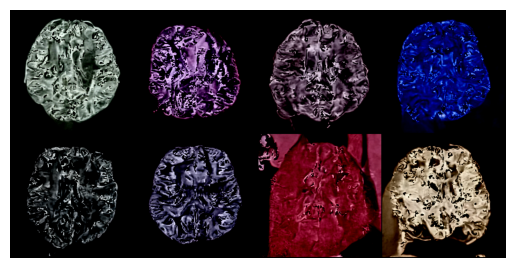

In [12]:
# @markdown Generate and plot some images:
x = torch.randn(8, 3, 256, 256).to(device)  # Batch of 8
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x, nrow=4)

# Display the images in grayscale mode
plt.imshow(grid.permute(1, 2, 0).cpu().squeeze(), cmap="gray")
plt.axis("off")
plt.show()

**Consideration 4:** Fine-tuning can be quite unpredictable! If we trained for a lot longer, we might see some perfect butterflies. But the intermediate steps can be extremely interesting in their own right, especially if your interests are more towards the artistic side! Explore training for very short or very long periods of time, and varying the learning rate to see how this affects the kinds of output the final model produces.

### Code for fine-tuning a model using the minimal example script we used on the WikiArt demo model

If you'd like to train a similar model to the one I made on WikiArt, you can uncomment and run the cells below. Since this takes a while and may exhaust your GPU memory, I recommend doing this _after_ working through the rest of this notebook.

In [ ]:
## To download the fine-tuning script:
# !wget https://github.com/huggingface/diffusion-models-class/raw/main/unit2/finetune_model.py

In [ ]:
## To run the script, training the face model on some vintage faces
## (ideally run this in a terminal):
# !python finetune_model.py --image_size 128 --batch_size 8 --num_epochs 16\
#     --grad_accumulation_steps 2 --start_model "google/ddpm-celebahq-256"\
#     --dataset_name "Norod78/Vintage-Faces-FFHQAligned" --wandb_project 'dm-finetune'\
#     --log_samples_every 100 --save_model_every 1000 --model_save_name 'vintageface'

### Saving and Loading Fine-Tuned Pipelines

Now that we've fine-tuned the U-Net in our diffusion model, let's save it to a local folder by running:

In [20]:
image_pipe.save_pretrained("my-finetuned-model")

As we saw in Unit 1, this will save the config, model, scheduler:

In [21]:
!ls {"my-finetuned-model"}

Next, you can follow the same steps outlined in Unit 1's [Introduction to Diffusers](https://github.com/huggingface/diffusion-models-class/blob/main/unit1/01_introduction_to_diffusers.ipynb) to push the model to the Hub for later use:

In [ ]:
# @title Upload a locally saved pipeline to the hub

# Code to upload a pipeline saved locally to the hub
from huggingface_hub import HfApi, ModelCard, create_repo, get_full_repo_name

# Set up repo and upload files
model_name = "ddpm-celebahq-finetuned-butterflies-2epochs"  # @param What you want it called on the hub
local_folder_name = "my-finetuned-model"  # @param Created by the script or one you created via image_pipe.save_pretrained('save_name')
description = "Describe your model here"  # @param
hub_model_id = get_full_repo_name(model_name)
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path=f"{local_folder_name}/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(
    folder_path=f"{local_folder_name}/unet", path_in_repo="", repo_id=hub_model_id
)
api.upload_file(
    path_or_fileobj=f"{local_folder_name}/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

# Add a model card (optional but nice!)
content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Example Fine-Tuned Model for Unit 2 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

{description}

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

'https://huggingface.co/lewtun/ddpm-celebahq-finetuned-butterflies-2epochs/blob/main/README.md'

Congratulations, you've now fine-tuned your first diffusion model!

For the rest of this notebook we'll use a [model](https://huggingface.co/johnowhitaker/sd-class-wikiart-from-bedrooms) I fine-tuned from [this model trained on LSUN bedrooms](https://huggingface.co/google/ddpm-bedroom-256) approximately one epoch on the [WikiArt dataset](https://huggingface.co/datasets/huggan/wikiart). If you'd prefer, you can skip this cell and use the faces/butterflies pipeline we fine-tuned in the previous section or load one from the Hub instead:

model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/938 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/benet/.cache/huggingface/hub/models--johnowhitaker--sd-class-wikiart-from-bedrooms/snapshots/85960f1e0e9d3c1eb2d8c5317a35eb5947e32e70: Error no file named diffusion_pytorch_model.safetensors found in directory /home/benet/.cache/huggingface/hub/models--johnowhitaker--sd-class-wikiart-from-bedrooms/snapshots/85960f1e0e9d3c1eb2d8c5317a35eb5947e32e70.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


0it [00:00, ?it/s]

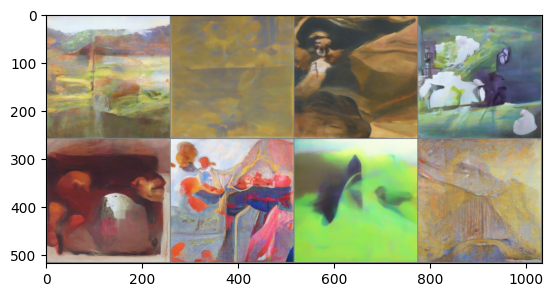

In [22]:
# Load the pretrained pipeline
pipeline_name = "johnowhitaker/sd-class-wikiart-from-bedrooms"
image_pipe = DDPMPipeline.from_pretrained(pipeline_name).to(device)

# Sample some images with a DDIM Scheduler over 40 steps
scheduler = DDIMScheduler.from_pretrained(pipeline_name)
scheduler.set_timesteps(num_inference_steps=40)

# Random starting point (batch of 8 images)
x = torch.randn(8, 3, 256, 256).to(device)

# Minimal sampling loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample

# View the results
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

**Consideration 5:** It is often hard to tell how well fine-tuning is working, and what 'good performance' means may vary by use-case. For example, if you're fine-tuning a text-conditioned model like stable diffusion on a small dataset you probably want it to **retain** most of its original training so that it can understand arbitrary prompts not covered by your new dataset, while **adapting** to better match the style of your new training data. This could mean using a low learning rate alongside something like exponential model averaging, as demonstrated [in this great blog post about creating a pokemon version of stable diffusion](https://lambdalabs.com/blog/how-to-fine-tune-stable-diffusion-how-we-made-the-text-to-pokemon-model-at-lambda). In a different situation, you may want to completely re-train a model on new data (such as our bedroom -> wikiart example) in which case a larger learning rate and more training makes sense. Even though the [loss plot](https://wandb.ai/johnowhitaker/dm_finetune/runs/2upaa341) is not showing much improvement, the samples clearly show a move away from the original data and towards more 'artsy' outputs, although they remain mostly incoherent.

Which leads us to a the next section, as we examine how we might add additional guidance to such a model for better control over the outputs...

## Guidance

What do we do if we want some control over the samples generated? For example, say we wanted to bias the generated images to be a specific color. How would we go about that? Enter **guidance**, a technique for adding additional control to the sampling process.

Step one is to create our conditioning function: some measure (loss) which we'd like to minimize. Here's one for the color example, which compares the pixels of an image to a target color (by default a sort of light teal) and returns the average error:

In [23]:
def color_loss(images, target_color=(0.1, 0.9, 0.5)):
    """Given a target color (R, G, B) return a loss for how far away on average
    the images' pixels are from that color. Defaults to a light teal: (0.1, 0.9, 0.5)"""
    target = (
        torch.tensor(target_color).to(images.device) * 2 - 1
    )  # Map target color to (-1, 1)
    target = target[
        None, :, None, None
    ]  # Get shape right to work with the images (b, c, h, w)
    error = torch.abs(
        images - target
    ).mean()  # Mean absolute difference between the image pixels and the target color
    return error

Next, we'll make a modified version of the sampling loop where, at each step, we do the following:
- Create a new version of x that has requires_grad = True
- Calculate the denoised version (x0)
- Feed the predicted x0 through our loss function
- Find the **gradient** of this loss function with respect to x
- Use this conditioning gradient to modify x before we step with the scheduler, hopefully pushing x in a direction that will lead to lower loss according to our guidance function

There are two variants here that you can explore. In the first, we set requires_grad on x **after** we get our noise prediction from the UNet, which is more memory efficient (since we don't have to trace gradients back through the diffusion model) but gives a less accurate gradient. In the second we set requires_grad on x **first**, then feed it through the UNet and calculate the predicted x0.

0it [00:00, ?it/s]

/tmp/ipykernel_609175/1982699028.py:40: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Image.fromarray(np.array(im * 255).astype(np.uint8))


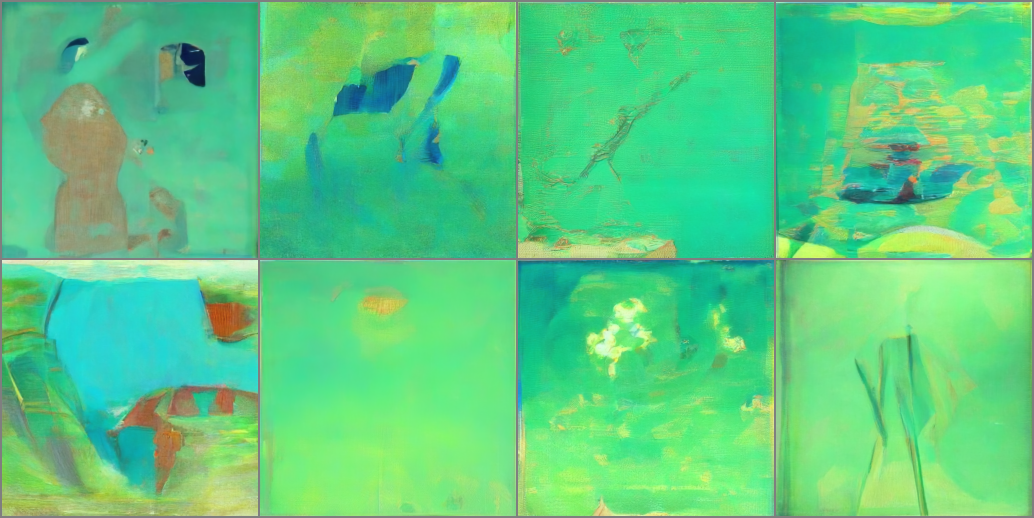

In [24]:
# Variant 1: shortcut method

# The guidance scale determines the strength of the effect
guidance_loss_scale = 40  # Explore changing this to 5, or 100

x = torch.randn(8, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Prepare the model input
    model_input = scheduler.scale_model_input(x, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Set x.requires_grad to True
    x = x.detach().requires_grad_()

    # Get the predicted x0
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    # Calculate loss
    loss = color_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "loss:", loss.item())

    # Get gradient
    cond_grad = -torch.autograd.grad(loss, x)[0]

    # Modify x based on this gradient
    x = x.detach() + cond_grad

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample

# View the output
grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

This second option requires nearly double the GPU RAM to run, even though we only generate a batch of four images instead of eight. See if you can spot the difference, and think through why this way is more 'accurate':

In [25]:
# Variant 2: setting x.requires_grad before calculating the model predictions

guidance_loss_scale = 40
x = torch.randn(4, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Set requires_grad before the model forward pass
    x = x.detach().requires_grad_()
    model_input = scheduler.scale_model_input(x, t)

    # predict (with grad this time)
    noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Get the predicted x0:
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    # Calculate loss
    loss = color_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "loss:", loss.item())

    # Get gradient
    cond_grad = -torch.autograd.grad(loss, x)[0]

    # Modify x based on this gradient
    x = x.detach() + cond_grad

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample


grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

0it [00:00, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacity of 10.91 GiB of which 38.38 MiB is free. Process 559680 has 4.42 GiB memory in use. Including non-PyTorch memory, this process has 6.43 GiB memory in use. Of the allocated memory 6.14 GiB is allocated by PyTorch, and 121.26 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In the second variant, the memory requirements are higher and the effect is less pronounced, so you may think that this is inferior. However, the outputs are arguably closer to the types of images the model was trained on, and you can always increase the guidance scale for a stronger effect. Which approach you use will ultimately come down to what works best experimentally.

In [ ]:
# Exercise: pick your favourite colour and look up it's values in RGB space.
# Edit the `color_loss()` line in the cell above to receive these new RGB values and examine the outputs - do they match what you expect?

## CLIP Guidance

Guiding towards a color gives us a little bit of control, but what if we could just type some text describing what we want?


[CLIP](https://openai.com/blog/clip/) is a model created by OpenAI that allows us to compare images to text captions. This is extremely powerful, since it allows us to quantify how well an image matches a prompt. And since the process is differentiable, we can use this as a loss function to guide our diffusion model!

We won't go too much into the details here. The basic approach is as follows:
- Embed the text prompt to get a 512-dimensional CLIP embedding of the text
- For every step in the diffusion model process:
  - Make several variants of the predicted denoised image (having multiple variations gives a cleaner loss signal)
  - For each one, embed the image with CLIP and compare this embedding with the text embedding of the prompt (using a measure called 'Great Circle Distance Squared')
- Calculate the gradient of this loss with respect to the current noisy x and use this gradient to modify x before updating it with the scheduler.

For a deeper explanation of CLIP, check out [this lesson on the topic](https://johnowhitaker.github.io/tglcourse/clip.html) or [this report on the OpenCLIP project](https://wandb.ai/johnowhitaker/openclip-benchmarking/reports/Exploring-OpenCLIP--VmlldzoyOTIzNzIz) which we're using to load the CLIP model. Run the next cell to load a CLIP model:

In [ ]:
# @markdown load a CLIP model and define the loss function
import open_clip

clip_model, _, preprocess = open_clip.create_model_and_transforms(
    "ViT-B-32", pretrained="openai"
)
clip_model.to(device)

# Transforms to resize and augment an image + normalize to match CLIP's training data
tfms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(224),  # Random CROP each time
        torchvision.transforms.RandomAffine(
            5
        ),  # One possible random augmentation: skews the image
        torchvision.transforms.RandomHorizontalFlip(),  # You can add additional augmentations if you like
        torchvision.transforms.Normalize(
            mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
        ),
    ]
)

# And define a loss function that takes an image, embeds it and compares with
# the text features of the prompt
def clip_loss(image, text_features):
    image_features = clip_model.encode_image(
        tfms(image)
    )  # Note: applies the above transforms
    input_normed = torch.nn.functional.normalize(image_features.unsqueeze(1), dim=2)
    embed_normed = torch.nn.functional.normalize(text_features.unsqueeze(0), dim=2)
    dists = (
        input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
    )  # Squared Great Circle Distance
    return dists.mean()

100%|████████████████████████████████████████| 354M/354M [00:02<00:00, 120MiB/s]


With a loss function defined, our guided sampling loop looks similar to the previous examples, replacing `color_loss()` with our new clip-based loss function:

0it [00:00, ?it/s]

Step: 0 , Guidance loss: 7.437869548797607
Step: 25 , Guidance loss: 7.174620628356934


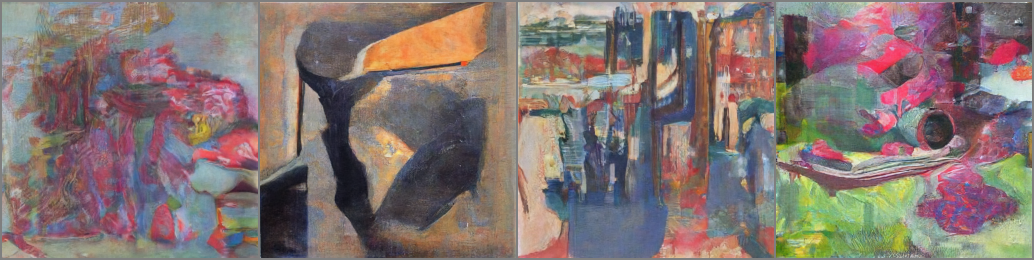

In [ ]:
# @markdown applying guidance using CLIP

prompt = "Red Rose (still life), red flower painting"  # @param

# Explore changing this
guidance_scale = 8  # @param
n_cuts = 4  # @param

# More steps -> more time for the guidance to have an effect
scheduler.set_timesteps(50)

# We embed a prompt with CLIP as our target
text = open_clip.tokenize([prompt]).to(device)
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = clip_model.encode_text(text)


x = torch.randn(4, 3, 256, 256).to(
    device
)  # RAM usage is high, you may want only 1 image at a time

for i, t in tqdm(enumerate(scheduler.timesteps)):

    model_input = scheduler.scale_model_input(x, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    cond_grad = 0

    for cut in range(n_cuts):

        # Set requires grad on x
        x = x.detach().requires_grad_()

        # Get the predicted x0:
        x0 = scheduler.step(noise_pred, t, x).pred_original_sample

        # Calculate loss
        loss = clip_loss(x0, text_features) * guidance_scale

        # Get gradient (scale by n_cuts since we want the average)
        cond_grad -= torch.autograd.grad(loss, x)[0] / n_cuts

    if i % 25 == 0:
        print("Step:", i, ", Guidance loss:", loss.item())

    # Modify x based on this gradient
    alpha_bar = scheduler.alphas_cumprod[i]
    x = (
        x.detach() + cond_grad * alpha_bar.sqrt()
    )  # Note the additional scaling factor here!

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample


grid = torchvision.utils.make_grid(x.detach(), nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

Those look sort of like roses! It's not perfect, but if you play around with the settings you can get some pleasing images with this.

If you examine the code above you'll see I'm scaling the conditioning gradient by a factor of `alpha_bar.sqrt()`. There is some theory showing the 'right' way to scale these gradients, but in practice this is also something you can experiment with. For some types of guidance, you may want most of the effect concentrated in the early steps, for others (say, a style loss focused on textures) you may prefer that they only kick in towards the end of the generation process. Some possible schedules are shown below:

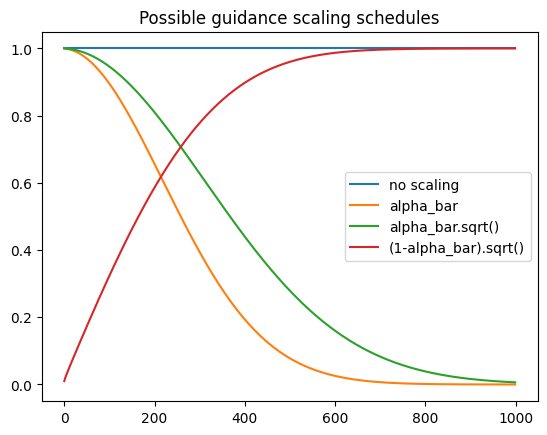

In [ ]:
# @markdown Plotting some possible schedules:
plt.plot([1 for a in scheduler.alphas_cumprod], label="no scaling")
plt.plot([a for a in scheduler.alphas_cumprod], label="alpha_bar")
plt.plot([a.sqrt() for a in scheduler.alphas_cumprod], label="alpha_bar.sqrt()")
plt.plot(
    [(1 - a).sqrt() for a in scheduler.alphas_cumprod], label="(1-alpha_bar).sqrt()"
)
plt.legend()
plt.title("Possible guidance scaling schedules");

Experiment with different schedules, guidance scales and any other tricks you can think of (clipping the gradients within some range is a popular modification) to see how good you can get this! Also make sure you try swapping in other models. Perhaps the faces model we loaded at the start - can you reliably guide it to produce a male face? What if you combine CLIP guidance with the color loss we used earlier? Etc.

If you check out [some code for CLIP-guided diffusion in practice](https://huggingface.co/spaces/EleutherAI/clip-guided-diffusion/blob/main/app.py), you'll see a more complex approach with a better class for picking random cutouts from the images and lots of additional tweaks to the loss function for better performance. Before text-conditioned diffusion models came along, this was the best text-to-image system there was! Our little toy version here has lots of room to improve, but it captures the core idea: thanks to guidance plus the amazing capabilities of CLIP, we can add text control to an unconditional diffusion model 🎨.

## Sharing A Custom Sampling Loop as a Gradio Demo

Perhaps you've figured out a fun loss to guide generation with, and you now want to share both your fine-tuned model and this custom sampling strategy with the world...

Enter [Gradio](https://gradio.app/). Gradio is a free and open-source tool that allows users to easily create and share interactive machine learning models through a simple web interface. With Gradio, users can build custom interfaces for their machine learning models, which can then be shared with others through a unique URL. It is also integrated into 🤗 Spaces which makes it easy to host demos and share them with others.

We'll put our core logic in a function that takes some inputs and produces an image as the output. This can then be wrapped in a simple interface that allows the user to specify some parameters (which are passed as inputs to the main generate function). There are many [components](https://gradio.app/docs/#components) available - for this example we'll use a slider for the guidance scale and a color picker to define the target color.

In [ ]:
%pip install -q gradio # Install the library

In [ ]:
import gradio as gr
from PIL import Image, ImageColor


# The function that does the hard work
def generate(color, guidance_loss_scale):
    target_color = ImageColor.getcolor(color, "RGB")  # Target color as RGB
    target_color = [a / 255 for a in target_color]  # Rescale from (0, 255) to (0, 1)
    x = torch.randn(1, 3, 256, 256).to(device)
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        model_input = scheduler.scale_model_input(x, t)
        with torch.no_grad():
            noise_pred = image_pipe.unet(model_input, t)["sample"]
        x = x.detach().requires_grad_()
        x0 = scheduler.step(noise_pred, t, x).pred_original_sample
        loss = color_loss(x0, target_color) * guidance_loss_scale
        cond_grad = -torch.autograd.grad(loss, x)[0]
        x = x.detach() + cond_grad
        x = scheduler.step(noise_pred, t, x).prev_sample
    grid = torchvision.utils.make_grid(x, nrow=4)
    im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
    im = Image.fromarray(np.array(im * 255).astype(np.uint8))
    im.save("test.jpeg")
    return im


# See the gradio docs for the types of inputs and outputs available
inputs = [
    gr.ColorPicker(label="color", value="55FFAA"),  # Add any inputs you need here
    gr.Slider(label="guidance_scale", minimum=0, maximum=30, value=3),
]
outputs = gr.Image(label="result")

# And the minimal interface
demo = gr.Interface(
    fn=generate,
    inputs=inputs,
    outputs=outputs,
    examples=[
        ["#BB2266", 3],
        ["#44CCAA", 5],  # You can provide some example inputs to get people started
    ],
)
demo.launch(debug=True)  # debug=True allows you to see errors and output in Colab

It is possible to build much more complicated interfaces, with fancy styling and a wide array of possible inputs, but for this demo we're keeping it as simple as possible.

Demos on 🤗 Spaces run on CPU by default, so it's nice to prototype your interface in Colab (as above) before migrating over. When you're ready to share your demo, you'll create a space, set up a `requirements.txt` file listing the libraries your code will use and then place all the code in an `app.py` file which defines the relevant functions and the interface.

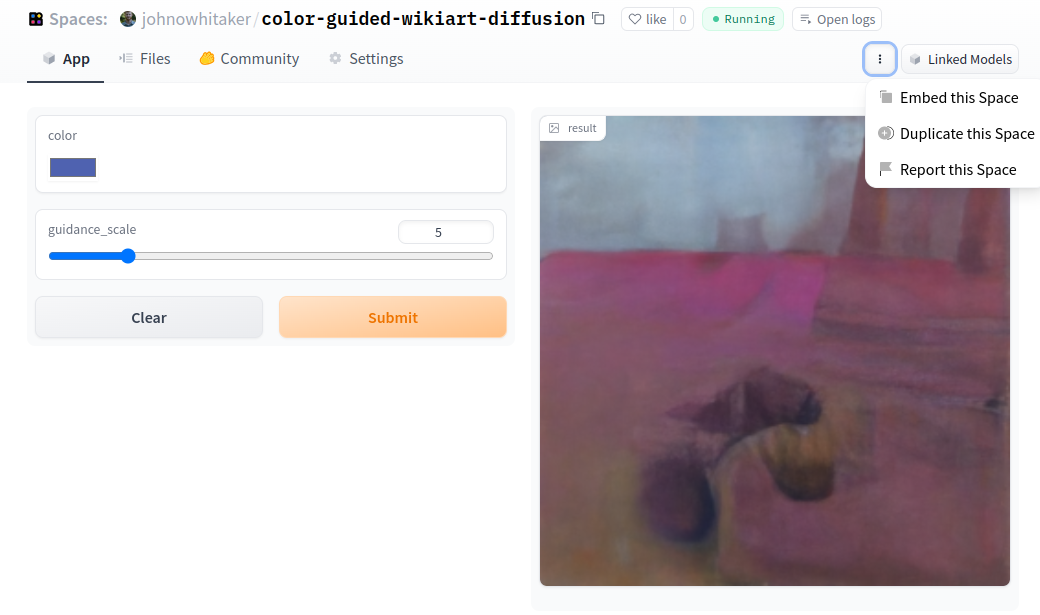

Lucky for you, there's also an option to 'Duplicate' a space. You can visit my demo space [here](https://huggingface.co/spaces/johnowhitaker/color-guided-wikiart-diffusion) (shown above) and click 'Duplicate this Space' to get a template which you can then modify to use your own model and guidance function.

In the settings, you can configure your space to run on fancier hardware (which is charged per hour). Made something amazing and want to share it on better hardware but don't have the money? Let us know via Discord and we'll see if we can help!

## Summary and Next Steps

We've covered a lot in this notebook! Let's recap the core ideas:
- It's relatively easy to load in existing models and sample them with different schedulers
- Fine-tuning looks just like training from scratch, except that by starting from an existing model we hope to get better results more quickly
- To fine-tune large models on big images, we can use tricks like gradient accumulation to get around batch size limitations
- Logging sample images is important for fine-tuning, where a loss curve might not show much useful information
- Guidance allows us to take an unconditional model and steer the generation process based on some guidance/loss function, where at each step we find the gradient of the loss with respect to the noisy image x and update it according to this gradient before moving on to the next timestep
- Guiding with CLIP let's us control unconditional models with text!


To put this into practice, here are some specific next steps you can take:
- Fine-tune your own model and push it to the hub. This will involve picking a starting point (e.g. a model trained on [faces](https://huggingface.co/google/ddpm-celebahq-256), [bedrooms](https://huggingface.co/fusing/ddpm-lsun-bedroom), [cats](https://huggingface.co/fusing/ddpm-lsun-cat) or the [wikiart example above](https://huggingface.co/johnowhitaker/sd-class-wikiart-from-bedrooms)) and a dataset (perhaps these [animal faces](https://huggingface.co/datasets/huggan/AFHQv2) or your own images) and then running either the code in this notebook or the example script (demo usage below).
- Explore guidance using your fine-tuned model, either using one of the example guidance functions (color_loss or CLIP) or inventing your own.
- Share a demo based on this using Gradio, either modifying the [example space](https://huggingface.co/spaces/johnowhitaker/color-guided-wikiart-diffusion) to use your own model or creating your own custom version with more functionality.

We look forward to seeing your results on Discord, Twitter, and elsewhere 🤗!